In [2]:
# -*- coding: UTF-8 -*-
"""
数据描述统计
预测股票的长短期记忆神经网络
评价统计性质
"""

# 保证脚本与Python3兼容
from __future__ import print_function

import numpy as np
import pandas as pd
import os
from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.model_selection import  train_test_split
import time #helper libraries
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import newaxis

import warnings

warnings.filterwarnings("ignore")

def readData(path):
    """
    使用pandas读取数据
    """
    data = pd.read_csv(path)
    cols = list(data.columns.values)
    return data[cols]

if __name__ == "__main__":
    # 设置显示格式
    pd.set_option('display.width', 1000)
    homePath = os.path.dirname(os.path.abspath('__file__'))
    # Windows下的存储路径与Linux并不相同
    if os.name == "nt":
        dataPath = "%s\\prices.csv" % homePath
    else:
        dataPath = "%s/prices.csv" % homePath
    prices = readData(dataPath)
    
    
    

In [4]:
#查看数据
prices.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [6]:
yahoo = prices[prices['symbol']=='YHOO']
yahoo_stock_prices = yahoo.close.values.astype('float32')  #取收盘价
yahoo_stock_prices = yahoo_stock_prices.reshape(1762, 1)   #转为数组
yahoo_stock_prices.shape

(1762, 1)

            date symbol       open      close        low       high      volume
713   2010-01-04   YHOO  16.940001  17.100000  16.879999  17.200001  16587400.0
1181  2010-01-05   YHOO  17.219999  17.230000  17.000000  17.230000  11718100.0
1649  2010-01-06   YHOO  17.170000  17.170000  17.070000  17.299999  16422000.0
2117  2010-01-07   YHOO  16.809999  16.700001  16.570000  16.900000  31816300.0
2585  2010-01-08   YHOO  16.680000  16.700001  16.620001  16.760000  15470000.0


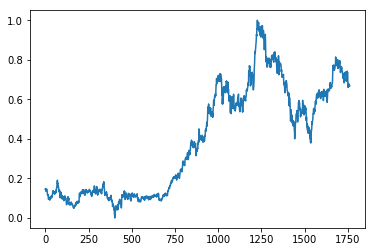

In [12]:
#查看价格趋势
print(yahoo.head())
plt.plot(yahoo_stock_prices)
plt.show()


In [10]:
# 标准化

scaler = MinMaxScaler(feature_range=(0, 1))
yahoo_stock_prices = scaler.fit_transform(yahoo_stock_prices)

## 划分训练集测试集
一般时间序列是按顺序排列，取前面一段时间数据，预测后面一个时间窗的数值。


In [14]:
train_size = int(len(yahoo_stock_prices) * 0.80)    #前80%数据作为训练
test_size = len(yahoo_stock_prices) - train_size
train, test = yahoo_stock_prices[0:train_size,:], yahoo_stock_prices[train_size:len(yahoo_stock_prices),:]
print(len(train), len(test))

1409 353


In [15]:
# 将数组转换为数据的矩阵
def create_dataset(dataset, look_back=1):   #look_back默认为1表示预测一天后的
	dataX, dataY = [], []    #dataX为原始数据列，y就是它下一天的值，转为自回归问题。
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]  #t+look_bak时刻之前的数据
		dataX.append(a)   
		dataY.append(dataset[i + look_back, 0])  #t+look_back的数据
	return np.array(dataX), np.array(dataY)

In [16]:
# reshape into X=t and Y=t+1
#t时刻以及t前的数据预测t+1时刻的值
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [19]:
trainX.shape 

(1407, 1)

In [22]:
#转为矩阵格式
trainX =  trainX.reshape(trainX.shape[0], 1, trainX.shape[1])  
testX = testX.reshape(testX.shape[0], 1, testX.shape[1])
trainX.shape

(1407, 1, 1)

## 构建模型

In [23]:

model = Sequential()  #初始化序列模型

model.add(LSTM(  
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
compilation time :  0.023905038833618164


## 训练模型


In [25]:
model.fit(
    trainX,
    trainY,
    batch_size=128,
    nb_epoch=10,
    validation_split=0.05)

Train on 1336 samples, validate on 71 samples
Epoch 1/10
1336/1336 [==============================] - 0s 70us/step - loss: 0.0019 - val_loss: 0.0019
Epoch 2/10
1336/1336 [==============================] - 0s 73us/step - loss: 0.0018 - val_loss: 3.5760e-04
Epoch 3/10
1336/1336 [==============================] - 0s 65us/step - loss: 0.0017 - val_loss: 4.5455e-04
Epoch 4/10
1336/1336 [==============================] - 0s 67us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 5/10
1336/1336 [==============================] - 0s 63us/step - loss: 0.0017 - val_loss: 6.6882e-04
Epoch 6/10
1336/1336 [==============================] - 0s 70us/step - loss: 0.0017 - val_loss: 3.4790e-04
Epoch 7/10
1336/1336 [==============================] - 0s 66us/step - loss: 0.0016 - val_loss: 3.5506e-04
Epoch 8/10
1336/1336 [==============================] - 0s 72us/step - loss: 0.0016 - val_loss: 5.0360e-04
Epoch 9/10
1336/1336 [==============================] - 0s 67us/step - loss: 0.0015 - val_loss: 6.3813e-04

## 预测


[[0.59106416]]
[[1.3321656]]
[[2.901965]]
[[6.2016664]]
[[10.801828]]
[[ 0.5910641]
 [ 1.3321655]
 [ 2.9019647]
 [ 6.2016654]
 [10.801827 ]]


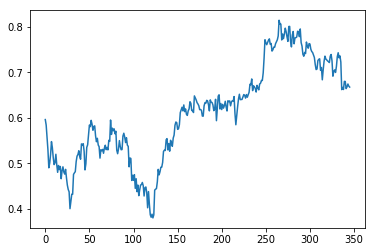

In [26]:
def plot_results_multiple(predicted_data, true_data,length):
    plt.plot(scaler.inverse_transform(true_data.reshape(-1, 1))[length:])
    plt.plot(scaler.inverse_transform(np.array(predicted_data).reshape(-1, 1))[length:])
    plt.show()
    
#predict lenght consecutive values from a real one
def predict_sequences_multiple(model, firstValue,length):
    prediction_seqs = []
    curr_frame = firstValue
    
    for i in range(length): 
        predicted = []        
        
        print(model.predict(curr_frame[newaxis,:,:]))
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        
        curr_frame = curr_frame[0:]
        curr_frame = np.insert(curr_frame[0:], i+1, predicted[-1], axis=0)
        
        prediction_seqs.append(predicted[-1])
        
    return prediction_seqs

predict_length=5
predictions = predict_sequences_multiple(model, testX[0], predict_length)
print(scaler.inverse_transform(np.array(predictions).reshape(-1, 1)))
plot_results_multiple(predictions, testY, predict_length)